In [1]:
import re
import os
import csv
import numpy as np
import joblib
from gensim import corpora
from collections import defaultdict
from pprint import pprint
from gensim.models import LdaModel
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def read_split(folder_path):
    '''
    read the splitted data into dic
    ----------------------------------
    Parameters :
        folder_path : str, the path to the folder containing all the split files
    Return:
        data : list, list of dic.
    '''
    data = []
    for file in os.listdir(folder_path):
        if '.split' in file:
            print(file)
            data += joblib.load(folder_path + file)
    
    return data


def Tf_IDF_Selection(documents, threshold=0.5):
    '''
    Drop the words in each news after split 
    if its tf-idf value is below the threshold.
    -------------------------------------------
    Parameters:
        documents : list, each element of the list is a dic of the read_split return.
        threshold : float, the threshold that determines which words to drop.
    Returns:
        top_words_per_document : list, each element is the selected list of words
    '''
    tfidf_vectorizer = TfidfVectorizer()

    # Creating TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(doc['news']) for doc in documents])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    print('Total Distinct words length : ', len(feature_names))
    print('Only keep : ', int(len(feature_names)*threshold))

    # Optimized selection
    top_words_per_document = []

    # Iterate over each document
    for i in range(tfidf_matrix.shape[0]):
        # Get TF-IDF array for the document and sort indices by value
        doc_vector = tfidf_matrix.getrow(i).toarray().flatten()
        sorted_indices = np.argsort(doc_vector)[::-1] # Descending order

        # Calculate the cutoff index for the top percent
        cutoff_index = int(len(sorted_indices) * threshold)

        # Select the top features
        top_features_indices = sorted_indices[:cutoff_index]
        top_words_set = set(feature_names[top_features_indices])

        # Map original words to their TF-IDF features, if they exist
        original_words = documents[i]['news']
        filtered_words = [word for word in original_words if word in top_words_set]

        top_words_per_document.append(filtered_words)
        
    for i in range(len(top_words_per_document)):
        documents[i]['news'] = top_words_per_document[i]

    return documents


def LDA(data, num_topics, passes):
    '''
    train the LDA model.
    -----------------------------
    Parameters:
        data : list, each element is a list of string, which is splitted, preprocessed and tf-idf selected news.
        num_topics : int, number of topics of the final result
        passes : int, Number of passes through the corpus during training.
        iterations : int, Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
    Return:
        topics : list of tuple. eahc tuple is the words and its weight in each topic.
    '''
    dictionary = corpora.Dictionary([i['news'] for i in data])
    corpus = [dictionary.doc2bow(text) for text in data]

    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes)

    return lda_model


def get_topics_frequency(data):
    '''
    get the topic frequency of each day
    ----------------------------------
    Parameter :
        data : list, the classified data or the return of classify()
    Returns :
        topic_frequency : 
    '''
    topic_count_per_day = defaultdict(lambda: defaultdict(int))
    
    for item in data:
        day = item['time'].date() 
        topic = item['topic'] 
        topic_count_per_day[day][topic] += 1

    topic_percentage_per_day = {}
    
    for day, topics in topic_count_per_day.items():
        total_topics = sum(topics.values())
        percentages = {topic: count / total_topics for topic, count in topics.items()}  # 计算每个topic的比例
        topic_percentage_per_day[day] = percentages
    
    return topic_percentage_per_day


def plot_network_graph(lda_model, num_topics=-1, num_words=10):
    '''
    plot a network graph using the trained lda_model.
    --------------------------------------------------
    Parameters:
        lda_model : gensim.models.LdaModel
        num_topics : int, topics to print out
        num_words : int, number of words within each topic to plot
    Returns:
        None.
    '''
    topics = lda_model.show_topics(num_topics=-1, num_words=10, formatted=False)
    edges = []
    for _, topic_words in topics:
        for word_info1 in topic_words:
            for word_info2 in topic_words:
                if word_info1 != word_info2:
                    edges.append((word_info1[0], word_info2[0]))

    # create graph
    G = nx.Graph()
    G.add_edges_from(edges)

    # plot
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
    plt.title("LDA Network Graph")
    plt.show()
    
    return None


def save_distribution_plot(data, plot=False):
    '''
    save the distribution plot of the data
    ---------------------------------------
    Parameters:
        data : list, the return of read_split
    Return:
        None
    '''
    daily_distribution = defaultdict(int)

    for item in data:
        time = item['time']
        daily_distribution[time.date()] += 1

    dates = list(daily_distribution.keys())
    counts = list(daily_distribution.values())

    plt.figure(figsize=(10, 6))
    plt.bar(dates, counts, color='skyblue')
    plt.title('Time Distribution of the data')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('./plot/time_distribution.png')
        
    return None


def classify(data, lda_model):
    '''
    classify the original data into topics after fitting the LDA model.
    -----------------------------------------------
    Parameters:
        data : dic, the return of read_split
        lda_model : gensim.models.LdaModel, the fitted model
    Return:
        data : dic, the input with data['topic'] = topic
    '''
    for i in data:
        doc_bow = lda_model.id2word.doc2bow(i['news'])
        topics = lda_model.get_document_topics(doc_bow)
        
        # Initialize variables to track max probability and corresponding topic
        max_prob = 0
        final_topic = 0
        
        # Find the topic with the highest probability
        for topic in topics:
            if topic[1] > max_prob:
                max_prob = topic[1]  # Update max_prob
                final_topic = topic[0]  # Update final_topic
        
        i['topic'] = final_topic
        
    return data


def save_topic_percentage_plot(topic_percentage_per_day, topic):
    '''
    save the plot of topic's frequency against time.
    ------------------------------------------
    Parameters : 
        topic_percentage_per_day : dic, the return of get_topics_frequency.
        topic : int, the topic you want to plot
    '''
    topic_data = {day: percentages.get(topic, 0.0) for day, percentages in sorted(topic_percentage_per_day.items())}
    
    # get time and frequency
    days = list(topic_data.keys())
    percentages = list(topic_data.values())
    
    # plot
    plt.figure(figsize=(10, 6))
    plt.plot(days, percentages, marker='o', linestyle='-')
    plt.title(f"Topic {topic + 1} Percentage Over Time")
    plt.xlabel("Date")
    plt.ylabel("Percentage")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'./plot/Frequency_Plot_of_topic{topic}')
    
    return None


def save_topic_data_to_csv(topic_percentage_per_day, filename="topic_data.csv"):
    '''
    save the topic percentage data to csv.
    ------------------------------------
    Parameters : 
        topic_percentage_per_day : dic, the return of get_topics_frequency.
        topic : int, the topic you want to plot
    '''
    global num_topics
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Date"] + [f"Topic_{i+1}" for i in range(num_topics)])  # 假设topic的范围是0到9
        for day, percentages in sorted(topic_percentage_per_day.items()):
            row = [day] + [percentages.get(topic, 0.0) for topic in range(10)]
            writer.writerow(row)

    print(f"Topic data has been saved to '{filename}'")
    
    return None

In [3]:
data = joblib.load('./FinanceNews.list')

In [4]:
from datetime import datetime
time_split = datetime.strptime('2023-1-1 00:00:00', '%Y-%m-%d %H:%M:%S')

data = [i for i in data if i['time'] > time_split]

LDA Parameters Set : num_topics : 10  passes : 5
Reading File...
Saving time distribution of data...
Tf-IDF Selection...
Total Distinct words length :  252012
Only keep :  126006
Fitting LDA model...
Adding topics to data...
Saving frequency plot...
Topic data has been saved to 'topic_data.csv'


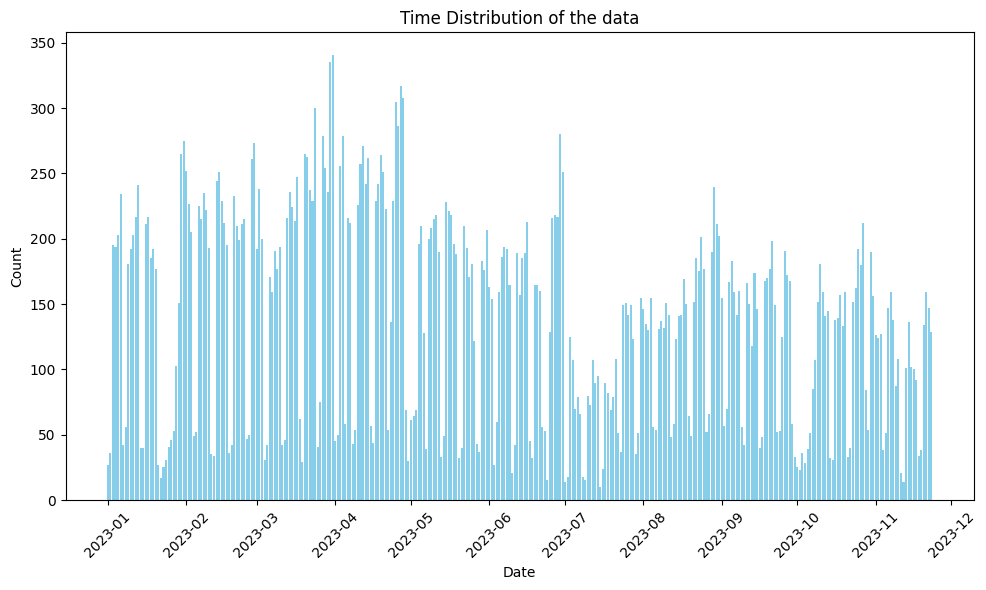

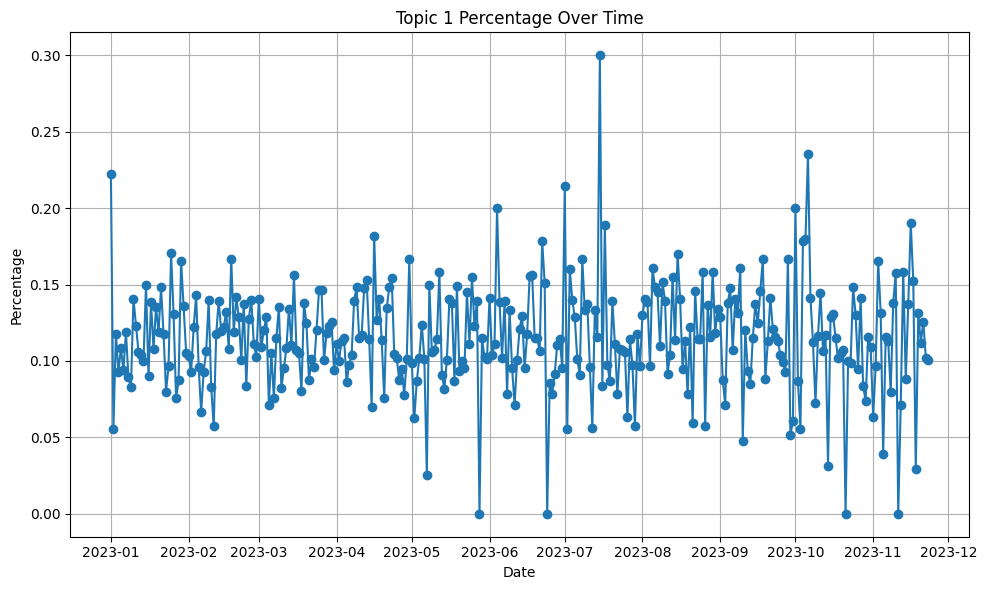

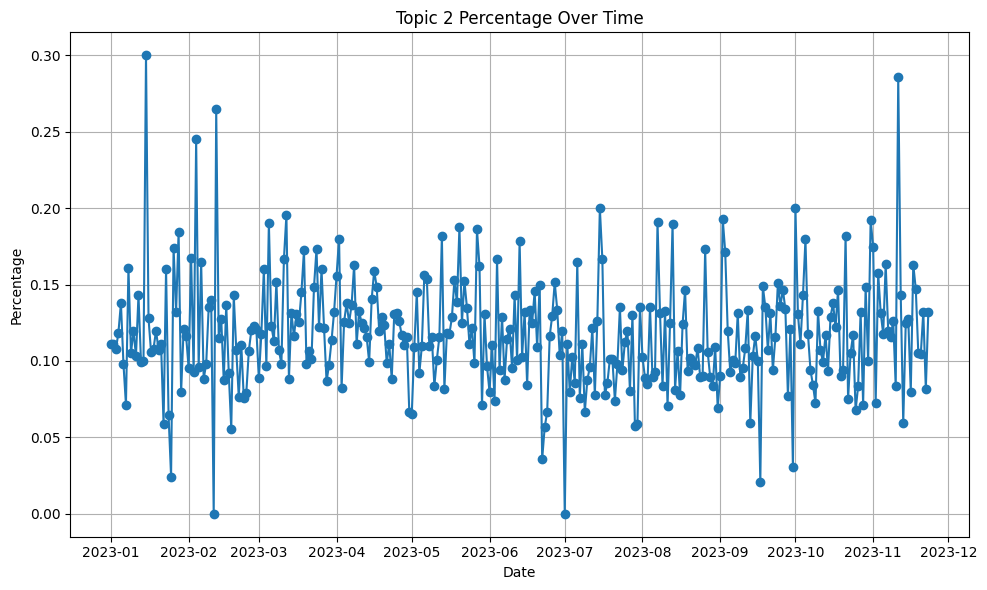

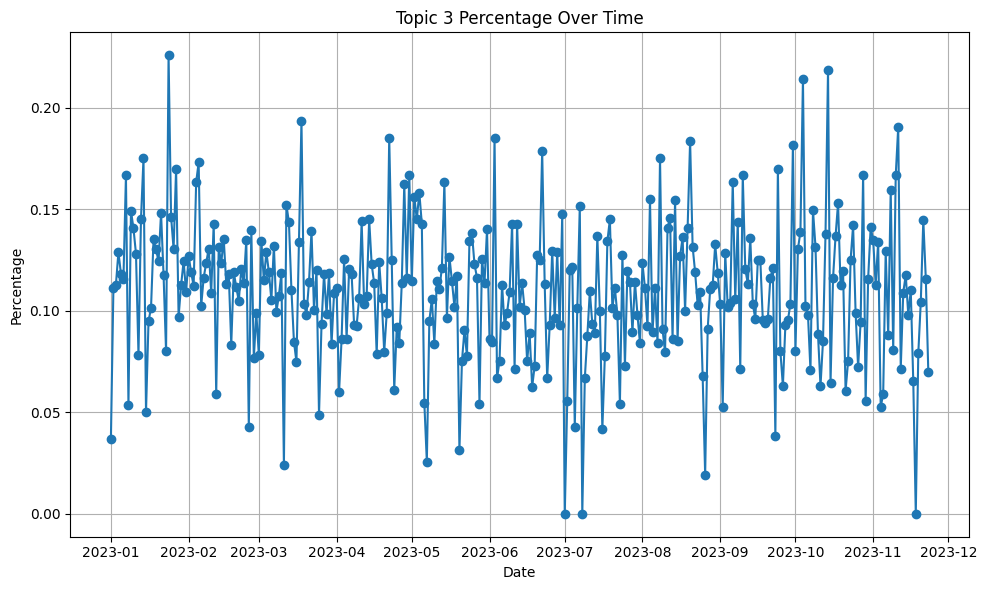

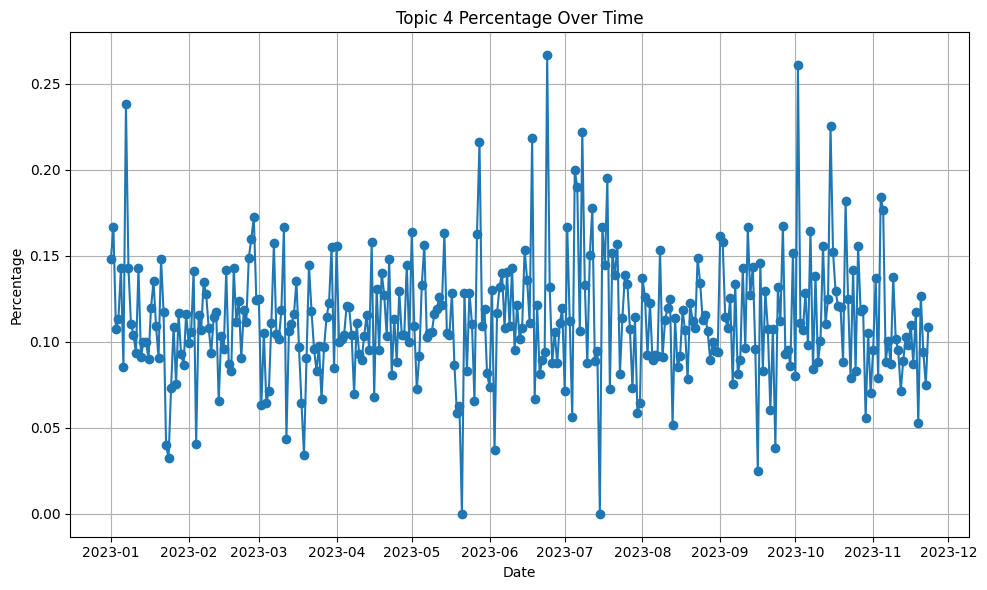

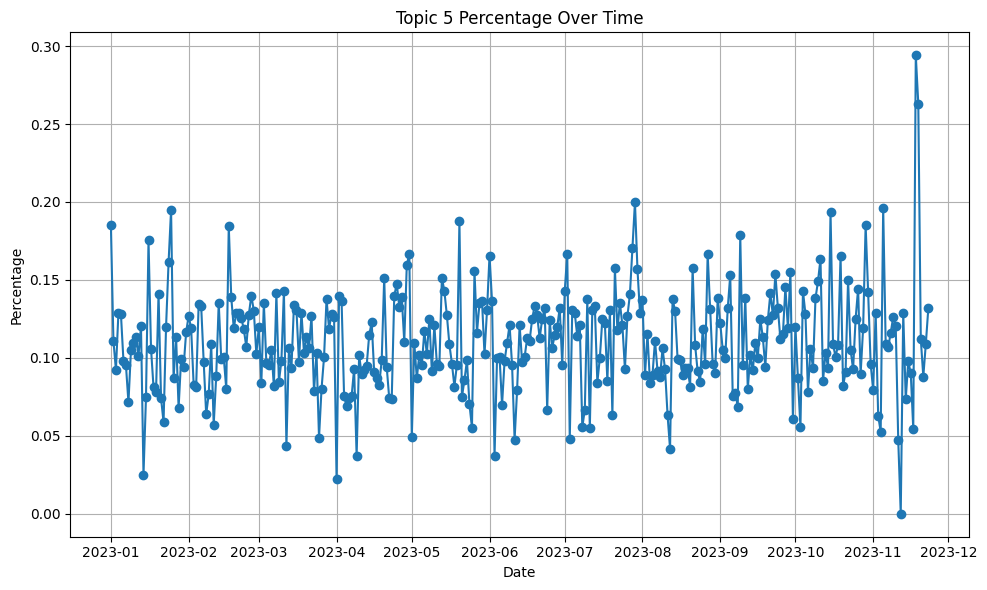

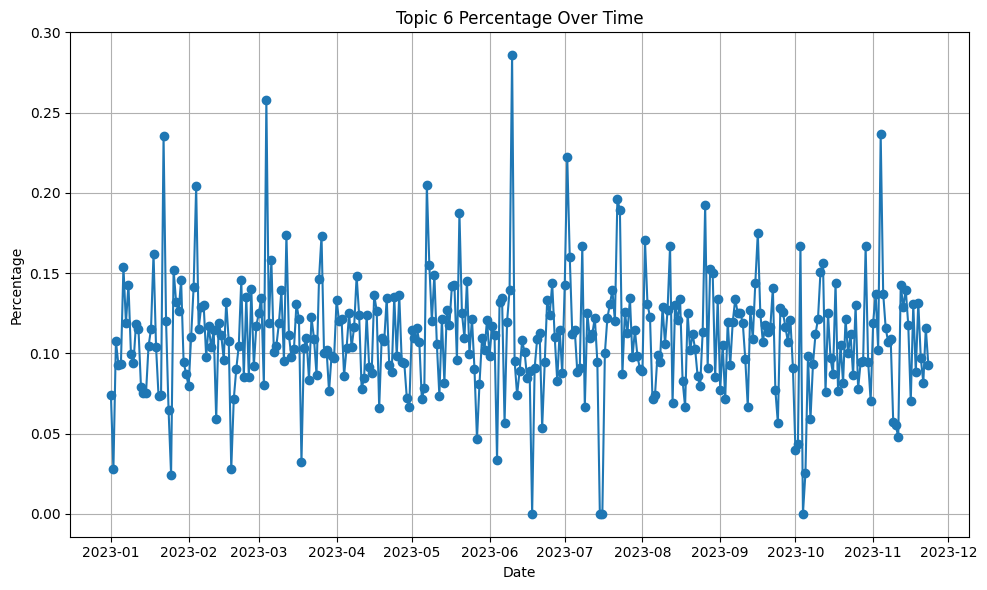

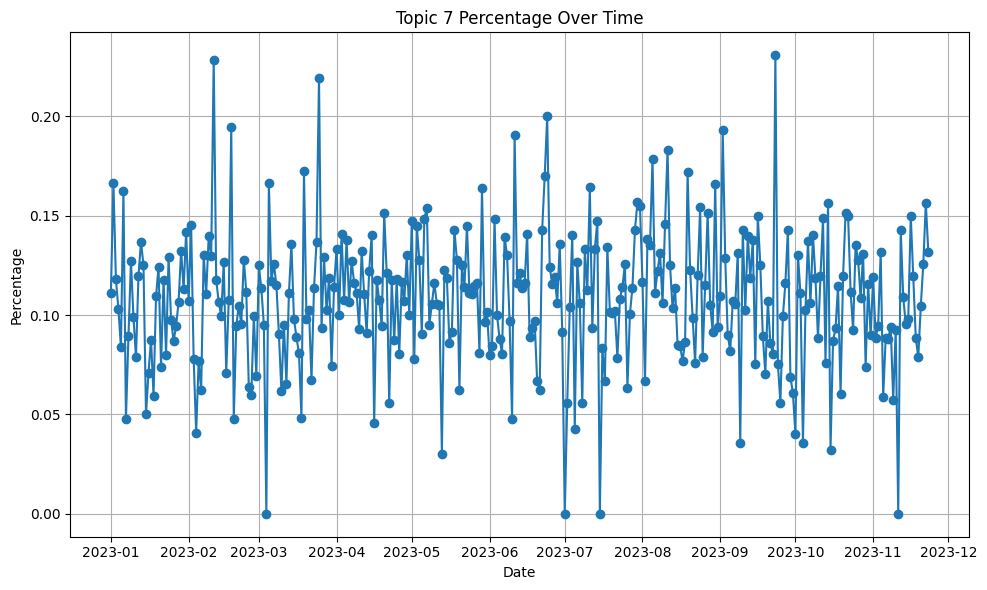

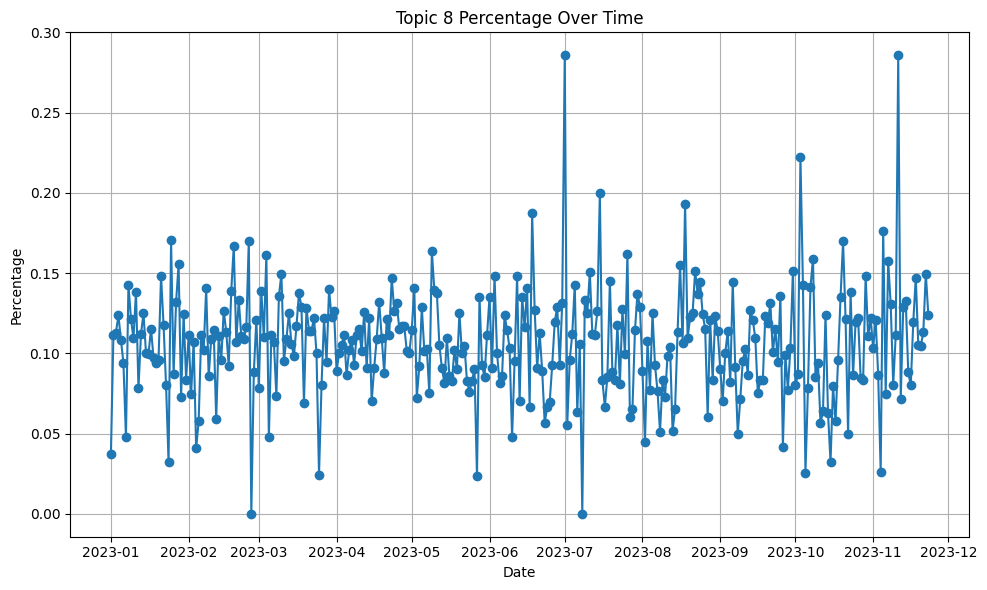

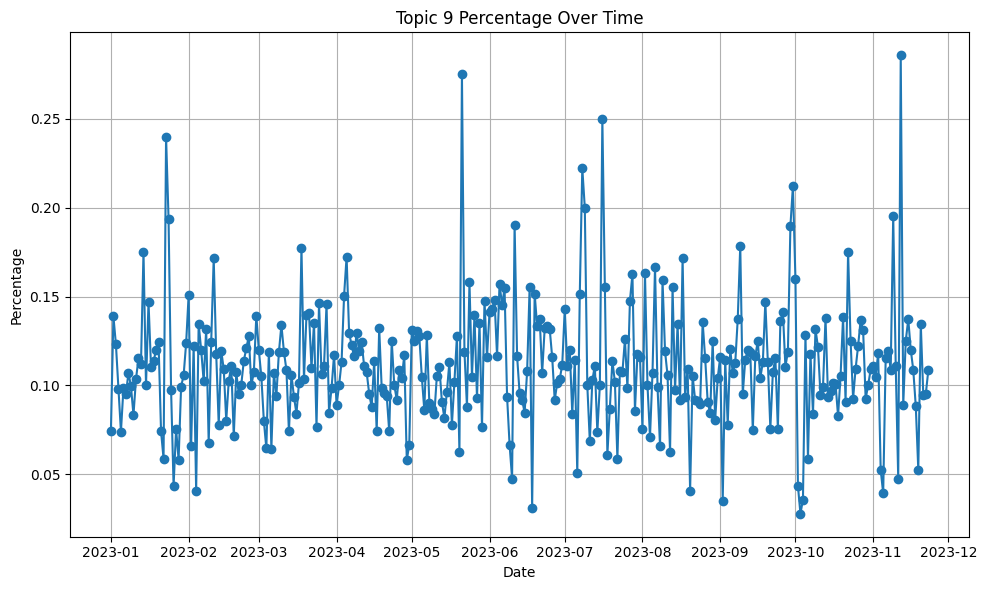

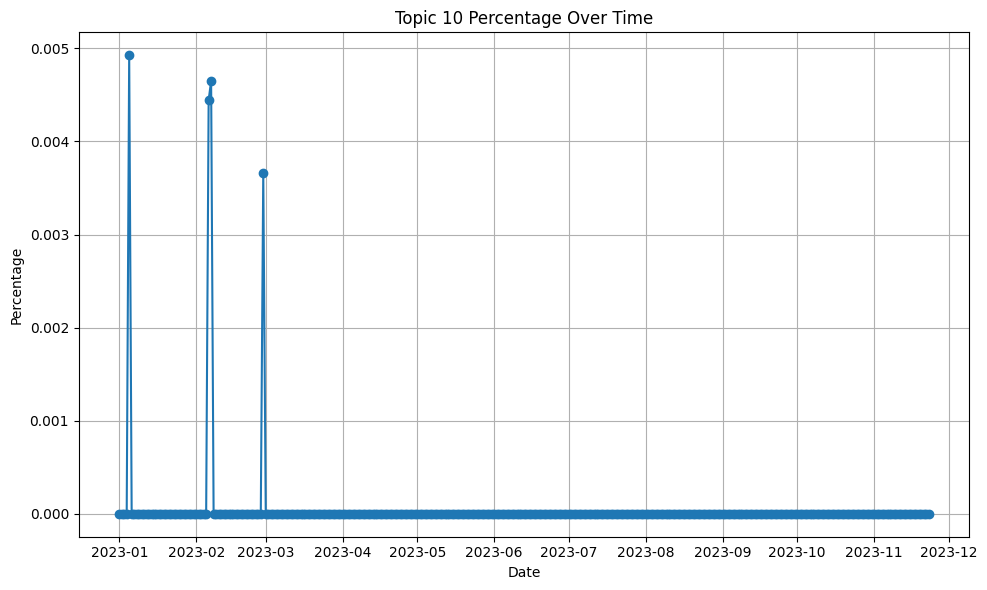

In [5]:
if __name__ == '__main__':

    # setting up parameters
    num_topics = 10
    passes = 5
    print('LDA Parameters Set : num_topics :', num_topics, ' passes :', passes)
    
    # read the file
    print('Reading File...')
    #data = joblib.load('./FinanceNews.list')
    
    # save time distribution plot of the data
    print('Saving time distribution of data...')
    save_distribution_plot(data)
    
    # tf-dif selection
    print('Tf-IDF Selection...')
    data = Tf_IDF_Selection(data)
    
    # LDA fitting
    print('Fitting LDA model...')
    lda_model = LDA(data, num_topics=num_topics, passes=passes)
    
    # add the topic
    print('Adding topics to data...')
    data = classify(data, lda_model)
    
    # get each topic's frequency distribution
    topics_fre = get_topics_frequency(data)
    
    # save the topic frequency plot
    print('Saving frequency plot...')
    for i in range(num_topics):
        save_topic_percentage_plot(topics_fre, i)
        
    # save_topic_data_to_csv
    save_topic_data_to_csv(topics_fre)